# Прогнозы и предсказания

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

1) выделить целевые группы клиентов;

2) предложить меры по снижению оттока;

3) определить другие особенности взаимодействия с клиентами.

Набор данных включает следующие поля:

- `churn` — факт оттока в текущем месяце;
Текущие поля в датасете:
Данные пользователя за предыдущий до проверки факта оттока месяц:
- `gender` — пол
- `near_Location` — проживание или работа в районе, где находится фитнес-центр
- `partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- `promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- `phone` — наличие контактного телефона
- `age` — возраст
- `lifetime` — время с момента первого обращения в фитнес-центр (в месяцах)
Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
- `contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- `month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах)
- `group_visits` — факт посещения групповых занятий
- `avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента
- `avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц
- `avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

## Шаг 1. Загрузка данных и проведем исследовательский анализ данных (EDA)

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set(style="ticks", color_codes=True); 
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist,pdist

In [2]:
gym_data = pd.read_csv("/datasets/gym_churn.csv")

display(gym_data.head())
print('-------------------------')

print('Размер исходной таблицы:')
print(gym_data.shape)
print('-------------------------')

print('Типы данных:')
print(gym_data.info())
print('-------------------------')

print('Пропущенные значения:')
print(gym_data.isna().sum())
print('-------------------------')

print('Количество дубликатов:')
print(gym_data.duplicated().sum())
print('-------------------------')

print('Изучим статистику:')
print(display(gym_data.describe()))
print('-------------------------')

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


-------------------------
Размер исходной таблицы:
(4000, 14)
-------------------------
Типы данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 n

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


None
-------------------------


Пропусков и дубликатов в данных нету. Типы данных указаны верно. Данные на первый взгляд выгедят чистенько.
Приведем только названия столбцов к строковым значениям:


Исходя из средних значений, мы можем сделать первые выводы:
    
- в основном клиенты находятся близко от нашего зала
- около 30% клиентов пользуются промо-кодами
- практически все клиенты оставили свой телефон
- средний возраст клиентов 29 лет
- женщин и мужчин примерно поровну

- в среднем за неделю зал помешают чуть меньше 2 раз, однако стандартное отклонение больше единицы, что может быть признаком большого разброса значений
- время с момента первого обращения в фитнес-центр в среднем около 4 месяцев, однако здесь также наблюдается большое стандартное отклонение, которое фактически равно среднему, что также показывает на большой разброс в наблюдениях по этому показателю


In [3]:
gym_data.columns = gym_data.columns.str.lower()

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался:

In [4]:
print('Средние значения кто ушел в отток и тех, кто остался')
gym_data.groupby('churn').\
    mean().\
    reset_index().\
    pipe(display)
print('-------------------------')

print('Медианные значения кто ушел в отток и тех, кто остался')
gym_data.groupby('churn').\
    median().\
    reset_index().\
    pipe(display)
print('-------------------------')

Средние значения кто ушел в отток и тех, кто остался


,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


-------------------------
Медианные значения кто ушел в отток и тех, кто остался


,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,1,1,1,0,1,6,0,30,149.881171,6.0,4,2.043252,2.046697
1,1,1,1,0,0,1,1,0,27,103.814686,1.0,1,1.491187,0.979445


-------------------------


Для большого количества признаков (таких как `promo_friends`, `contract_period`, `month_to_end_contract`, `group_visits`, `lifetime`, `avg_class_frequency_current_month`) наблюдается существенный перекос в средних значениях в пользу клиентов, не попадающих под критерий оттока.


Сравним средние значения для 2 групп (попали в отток и не попали):
    
- количество мужчин и женщин равное количество
- промо-кодами и партнерскими предложениями клиенты, попавшие в отток, пользуются гораздо реже
- групповые занятия такие клиенты тоже посещабт в 2 раза реже    
- средний возраст клиентов, попавших в отток на 3 года ниже - это существенно!
- среднее количество месяцев до окончания контракта в 6 раз меньше!
- денег в фитнес-баре такие клиенты оставляю также в 2 раза меньше    


Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток):

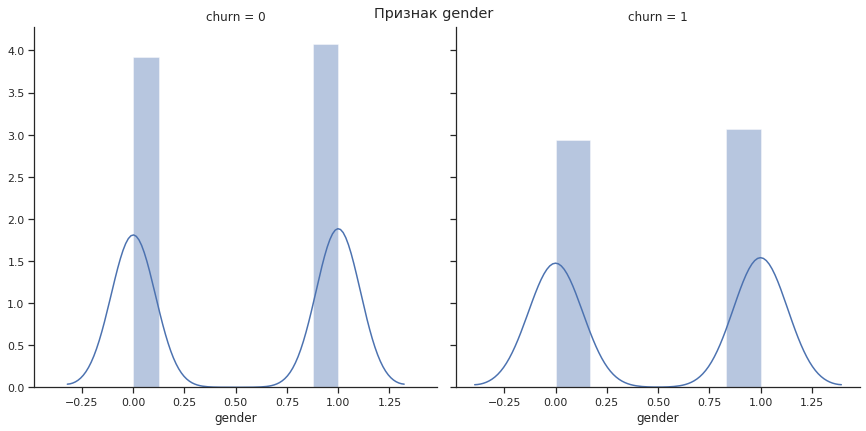

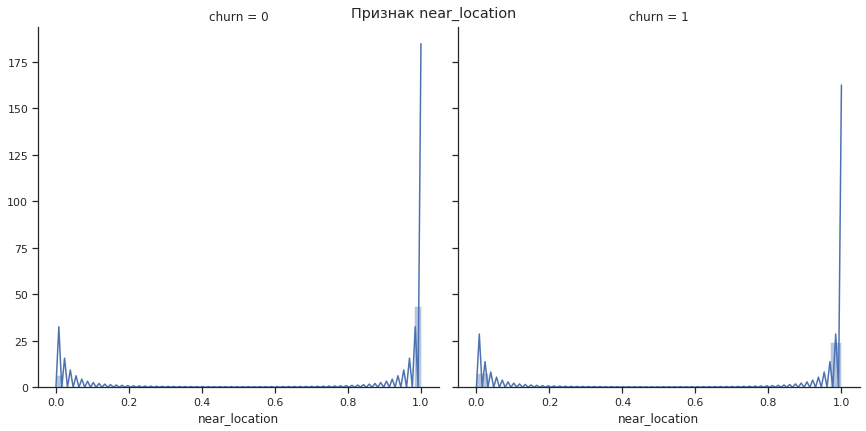

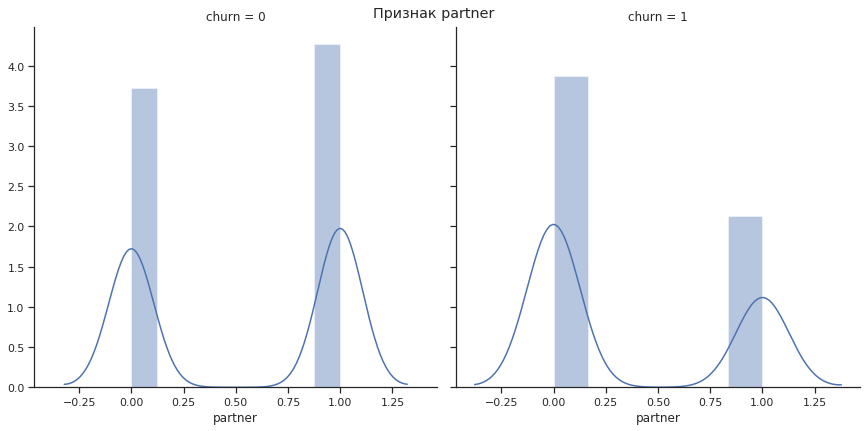

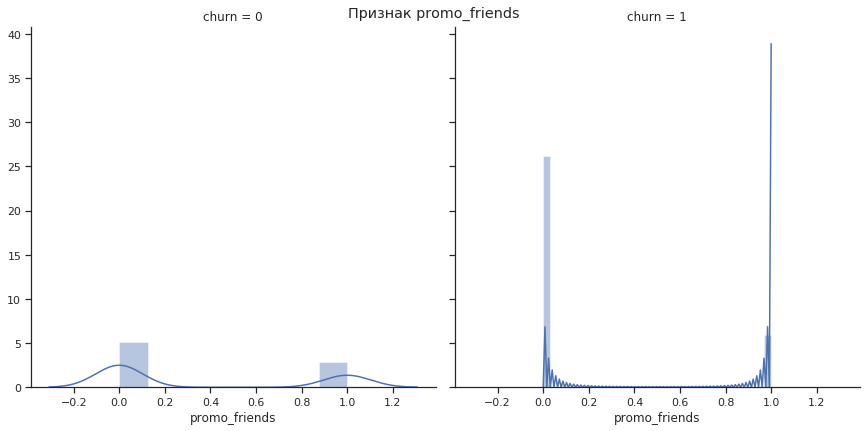

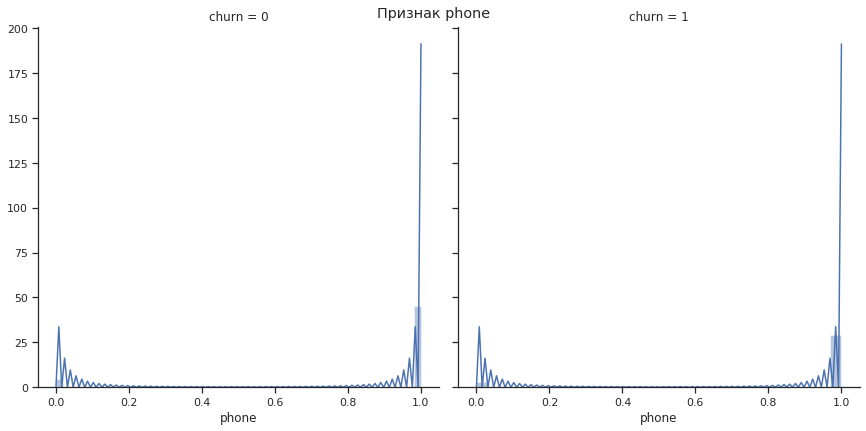

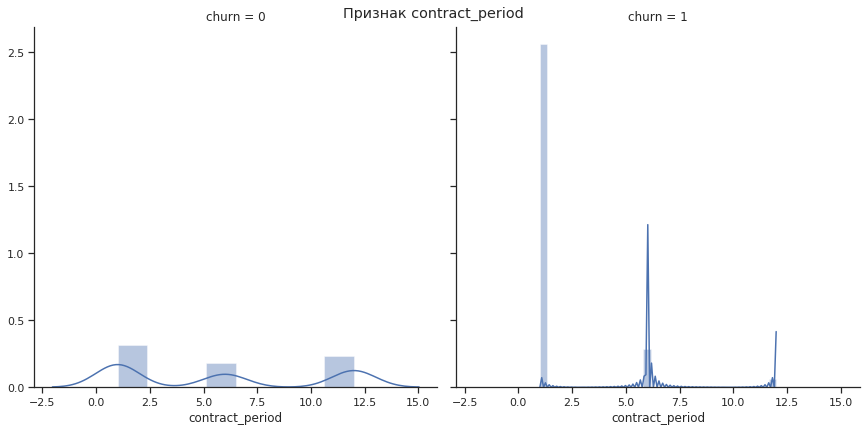

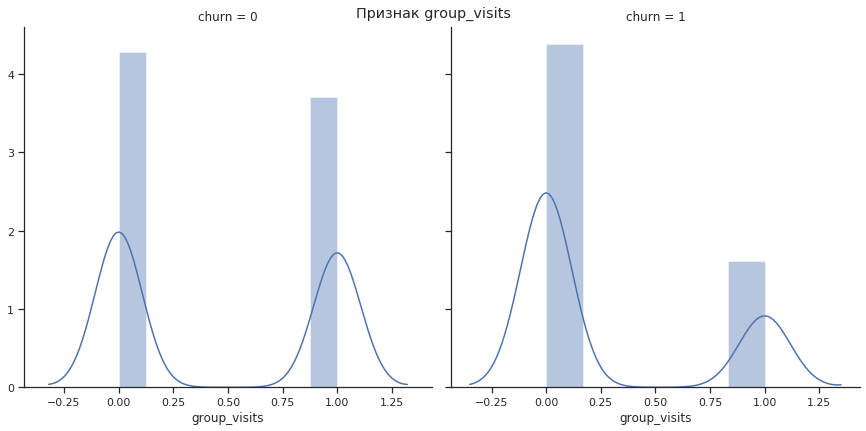

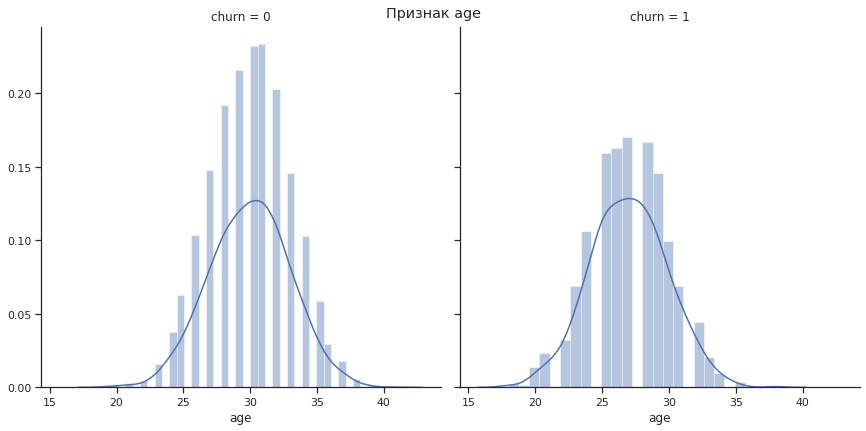

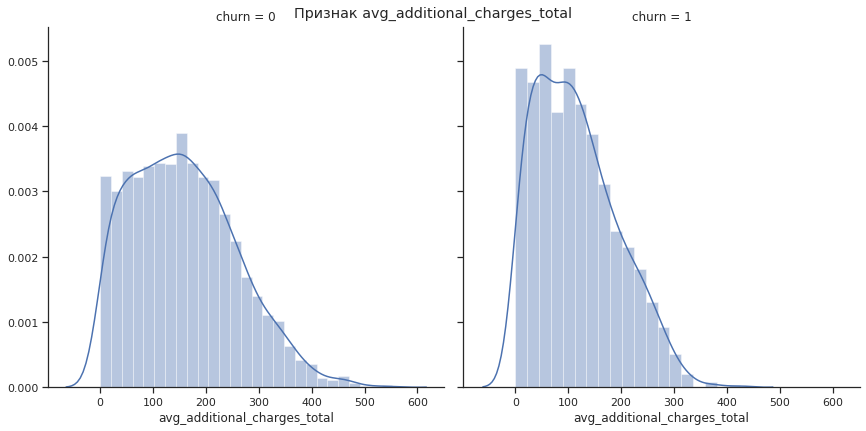

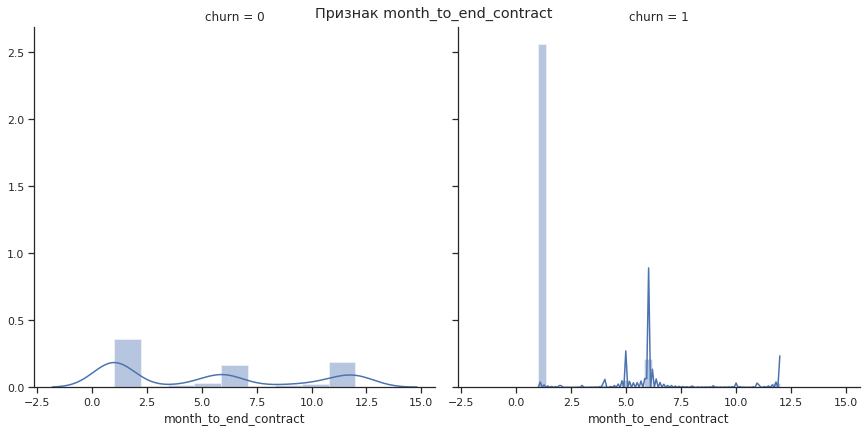

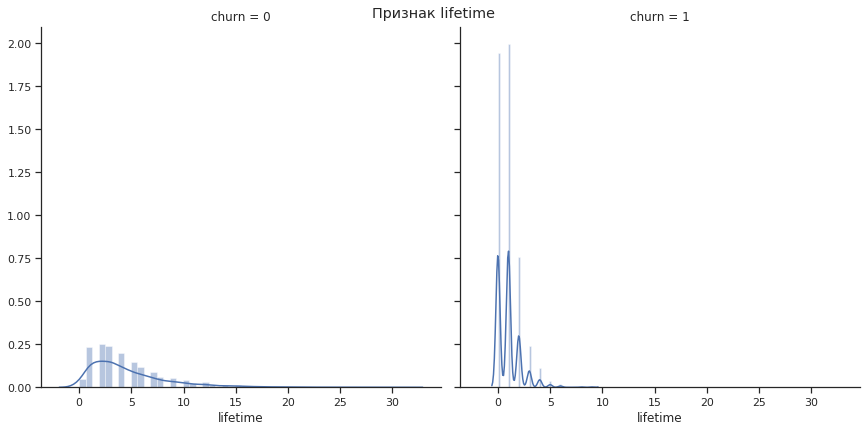

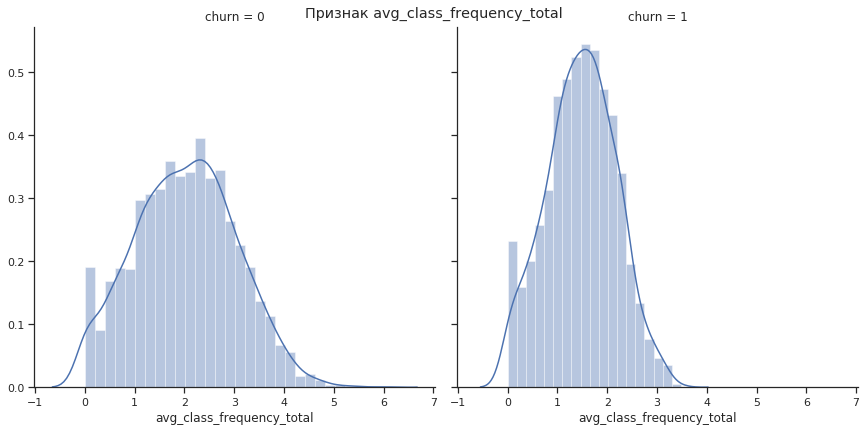

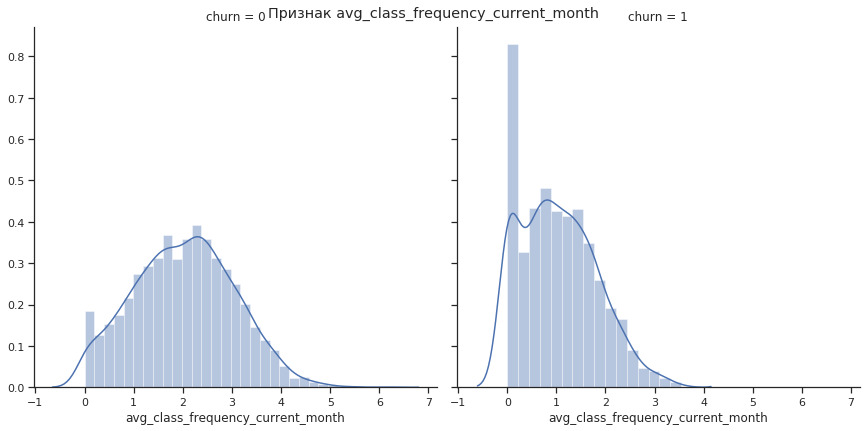

In [5]:
# col_wrap=2 убирает по оси y. col_wrap=1 по оси х (еще можно использовать sharey = True)
for column in gym_data.drop('churn',axis=1).columns:
    g = sns.FacetGrid(gym_data, col='churn', height=6.1, col_wrap=2) #, sharey = True
    g = (g.map(sns.distplot, column, hist=True, rug=False))
    g.fig.suptitle(f'Признак {column}')

Из гистограмм видно, что распределение ряда признаков (`month_to_end_contract`, `lifetime`, `avg_class_frequency_current_month`) скошены влево.

Построим теперь матрицу корреляций признаков.

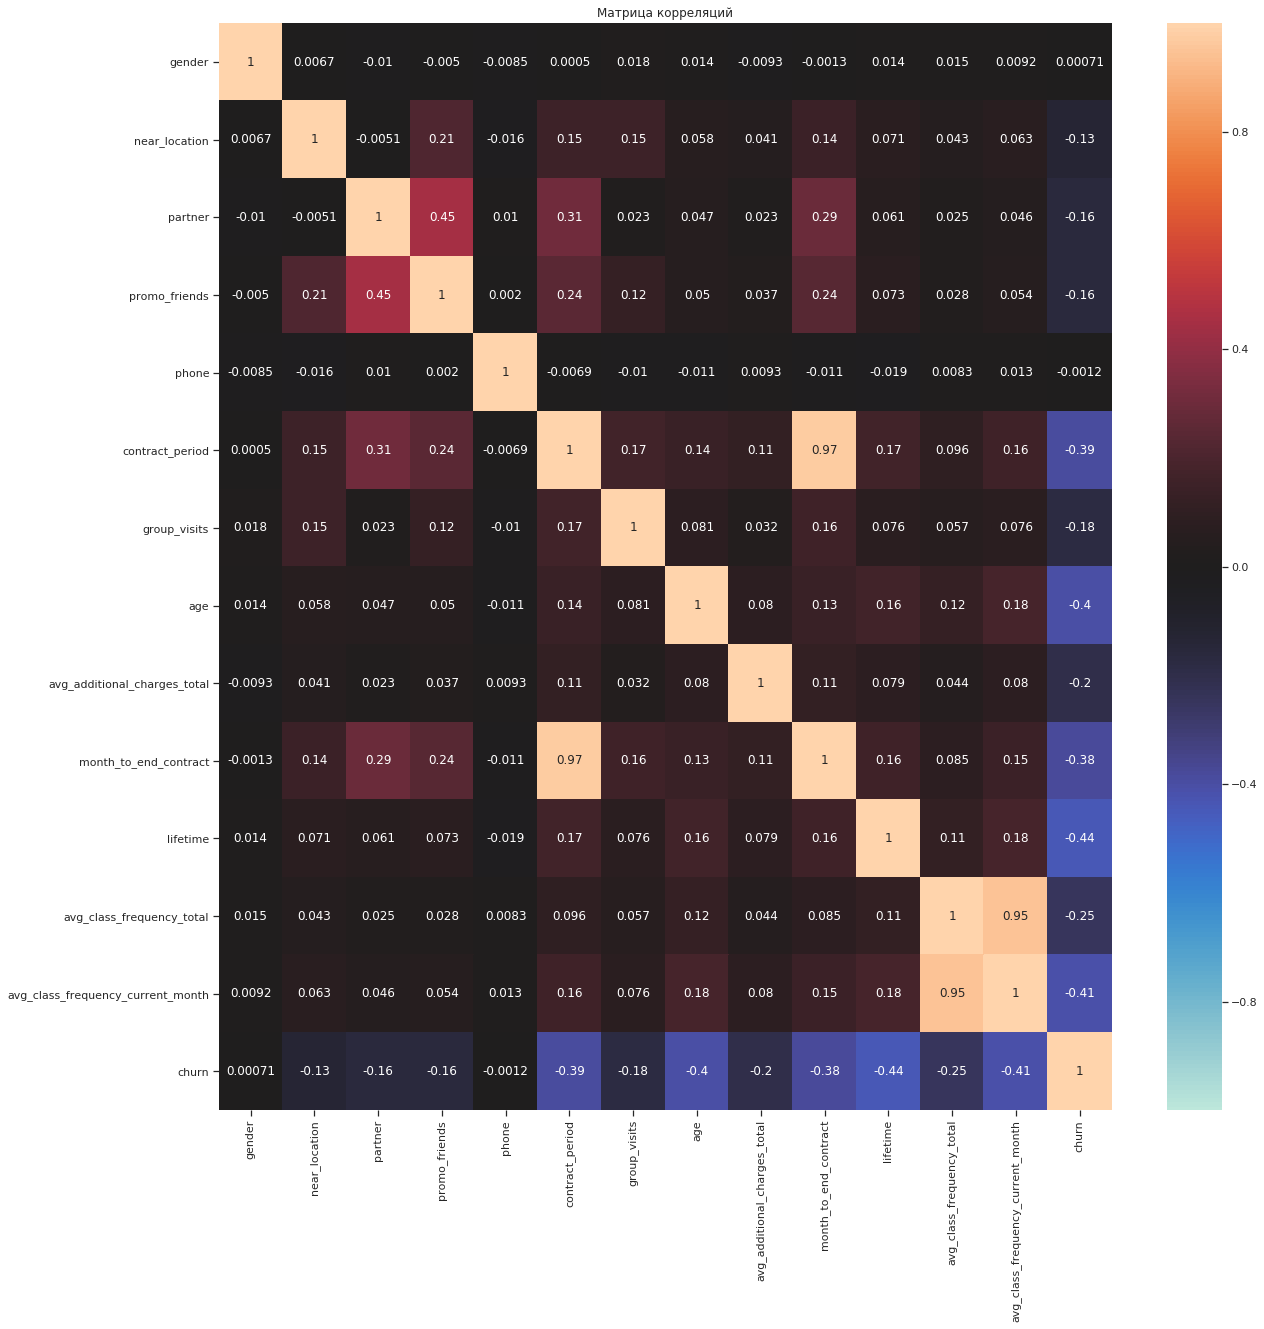

In [6]:
plt.figure(figsize=(20, 20))
sns.heatmap(gym_data.corr(), annot=True, vmin=-1, vmax=1, center= 0)
plt.title('Матрица корреляций')
plt.show()

Из таблицы видно следующие корреляции между признаками:
- `avg_class_frequency_total` и `avg_class_frequency_current_month`
- `contract_period` и `month_to_end_contract`


Из таблицы можно подметить следующие факты:
    
    - зависимость между использованием партнерской программы и использованием промо-кодов прослеживается
    - есть не ярко выраженная зависимость между сроком до окончания контракта и оттоком, а также возрастом и оттоком

У остальных признаков существенной зависимости не наблюдается.

## Шаг 2. Построим модель прогнозирования оттока пользователей

**Будем решать задачу бинарной классификации: 0 - клиент остался, 1 - клиент ушел.** 

Построим модель прогнозирования оттока клиентов с помощью алгоритма **линейной регресии**, а также **деревьев решений**.

Вспомним, что если коэффициент корреляции между двумя признаками слишком большой (больше 0.8), мы получим нерепрезентативные веса и переобученную под эти признаки модель. Таким образом нам необходимо избавиться от двух признаков. Создадим новый датафрейм, без скоррелированных столбцов и попробуем обчуить модель как с учетом корреляций, так и без. 

Также стоит отметить, что для деревьев данная процедура не является необходимой.

In [7]:
X_cut = gym_data.drop(columns=['avg_class_frequency_current_month','month_to_end_contract','churn'])

In [8]:
def make_prediction(m, X_train, y_train, X_test, y_test):
    """
        Ф-ция обучает модель и возвращает значения метрик Accuracy, Precision, Recall, F1, ROC_AUC
    """
    model = m
    model.fit(X_train, y_train)
    
    # рассчитаем прогноз
    predictions = model.predict(X_test)
    # получим вероятность принадлежности объекта к первому или второму классу
    probabilities = model.predict_proba(X_test)[:,1]
        
    print(f'Model name: {m}')
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
    print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
    print('F1: {:.2f}'.format(f1_score(y_test, predictions)))
    print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities)))
    print('-------------------------------------------------')

Построим модель с помощью **логистической регрессии** и **ансамбля деревьев** на обрезанных данных.

In [9]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X_cut = gym_data.drop(columns=['avg_class_frequency_current_month','month_to_end_contract','churn'])
y = gym_data['churn']

# разделяем модель на обучающую и валидационную выборку
# каждый раз, когда мы запускаем разбивку без указания random_state, получаем другой результат
# если random_state=some_number мы гарантируем, что вывод Run 1 будет равен выходу Run 2
# этот параметр следует удалить после тестирования модели
X_cut_train, X_cut_test, y_train, y_test = train_test_split(X_cut, y, test_size=0.2, stratify = y, random_state=1)

# обучите StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_cut_train)

# Преобразуйте обучающий и валидационные наборы данных
X_cut_train_st = scaler.transform(X_cut_train)
X_cut_test_st = scaler.transform(X_cut_test)

# модель логистической регрессии и деревья решений
models = [LogisticRegression(random_state=0,solver='liblinear'),RandomForestClassifier(n_estimators = 100,random_state=0),\
          DecisionTreeClassifier(random_state=0)]

# построим модели как для стандартизированных данных, так и для не стандартизированных данных
# выведем необходимые метрики качества моделей
print('Модели, построенные на НЕ СТАНДАРТИЗИРОВАННЫХ данных:')
for i in models:
    make_prediction(i, X_cut_train, y_train, X_cut_test, y_test)
    
print('Модели, построенные на СТАНДАРТИЗИРОВАННЫХ данных:')
for i in models:
    make_prediction(i, X_cut_train_st, y_train, X_cut_test_st, y_test)    

Модели, построенные на НЕ СТАНДАРТИЗИРОВАННЫХ данных:
Model name: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy: 0.90
Precision: 0.85
Recall: 0.77
F1: 0.81
ROC_AUC: 0.96
-------------------------------------------------
Model name: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_sta

Построим модель методом RandomForestClassifier() или **ансамблем деревьев** , где удалять скоррелированные признаки не обязательно.

In [10]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = gym_data.drop(columns = ['churn'])
y = gym_data['churn']

# разделяем модель на обучающую и валидационную выборку
# каждый раз, когда мы запускаем разбивку без указания random_state, получаем другой результат
# если random_state=some_number мы гарантируем, что вывод Run 1 будет равен выходу Run 2
# этот параметр следует удалить после тестирования модели
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# обучите StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуйте обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# модель логистической регрессии и деревья решений
models = [RandomForestClassifier(n_estimators = 100,random_state=0),DecisionTreeClassifier(random_state=0)]

# построим модели как для стандартизированных данных, так и для не стандартизированных данных
# выведем необходимые метрики качества моделей
print('Модели, построенные на НЕ СТАНДАРТИЗИРОВАННЫХ данных:')
for i in models:
    make_prediction(i, X_train, y_train, X_test, y_test)
    
print('Модели, построенные на СТАНДАРТИЗИРОВАННЫХ данных:')
for i in models:
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)    

Модели, построенные на НЕ СТАНДАРТИЗИРОВАННЫХ данных:
Model name: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Accuracy: 0.92
Precision: 0.87
Recall: 0.83
F1: 0.85
ROC_AUC: 0.97
-------------------------------------------------
Model name: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fract


Видим, что модель случайного леса стала работать лучше. По всем метрикам случайный лес выглядит лучше, хотя логистическая регрессия тоже показывает отличные результаты. Для дальнейшего прогноза оттока можно использовать обе модели.


## Шаг 3. Сделаем кластеризацию пользователей

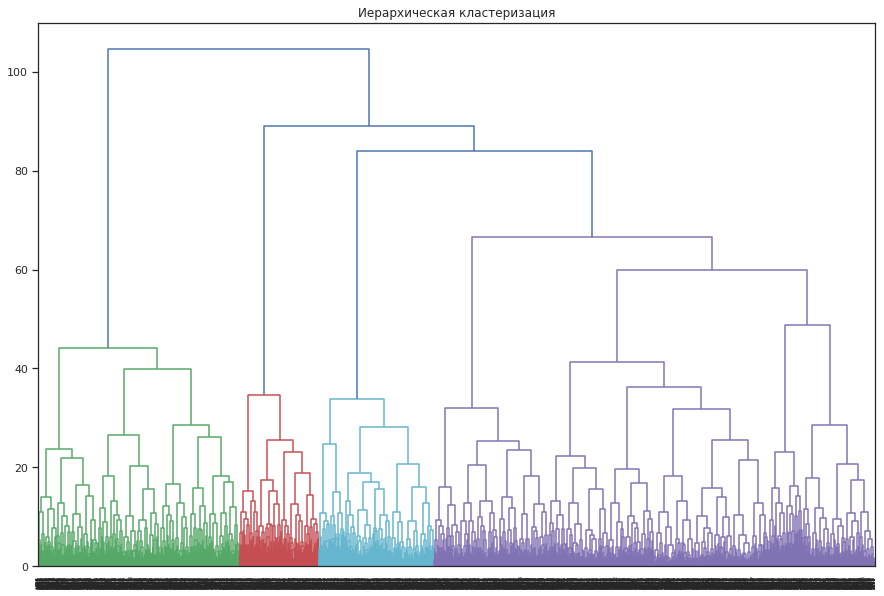

In [11]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# расстояния будем считать методом Варда
# Сначала в обоих кластерах для всех имеющихся наблюдений производится расчёт средних значений отдельных переменных. 
# Затем вычисляются квадраты евклидовых расстояний от отдельных наблюдений каждого кластера до этого 
# кластерного среднего значения. Эти дистанции суммируются. Потом в один новый кластер объединяются те кластера, 
# при объединении которых получается наименьший прирост общей суммы дистанций.
linked = linkage(X_sc, method = 'ward')

# нарисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

Дендрограмма показывает, что **оптимальное количество кластеров 4**. Попробуем убедиться этом еще несколькими способами.

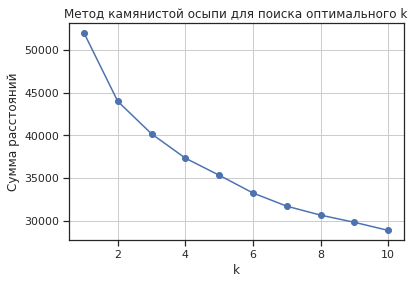

Text(0.5, 1.0, 'Elbow for KMeans clustering')

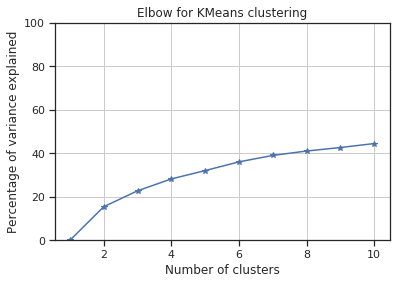

In [12]:
# выберем рассматриваемое количество кластеров
K = range(1, 11)

# расчитаем можели для каждого количества
models_clasters = [KMeans(n_clusters=k, random_state=1).fit(X_sc) for k in K]

# найдем внутрикластерную сумму расстояний
dist = [model.inertia_ for model in models_clasters]

# расчитаем сумму квадратов попарных расстояний между всем наблюдениями / число наблюдений
tss = sum(pdist(X_sc)**2)/X_sc.shape[0] 
bss = tss - dist

# построим 
plt.plot(K, dist, marker='o')
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Сумма расстояний')
plt.title('Метод камянистой осыпи для поиска оптимального k')
plt.show()

plt.plot(K, bss/tss*100, 'b*-')
plt.grid(True)
plt.ylim((0,100))
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Elbow for KMeans clustering')

Построим график расстояний между соединяемыми кластерами.

Объект ```linked``` представляет собой матрицу ```(n-1) x 4```, где ```n``` -- число наблюдений. Каждая строка матрицы представляет собой результат слияния очередной пары кластеров с номерами ```linked[i, 0]``` и ```linked[i, 1]```. Новому кластеру присваивается номер ```n + i```. ```linked[i, 2]``` содержит расстояние между объединяемыми кластерами, а ```linked[i, 3]``` -- размер нового кластера.

Построим график зависимости расстояний между кластерами от шага слияния (обратного), и посмотрим, начиная с какого момента это расстояние перестанет значительно меняться

[1.00990653e-01 1.22634574e-01 1.28123291e-01 ... 8.38725499e+01
 8.89563592e+01 1.04627601e+02]


(0, 20)

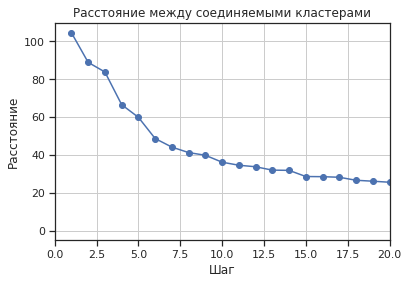

In [13]:
dist_lin = linked[:, 2]
print(dist_lin)

dist_rev = dist_lin[::-1] # отразим
idxs = range(1, len(dist_lin) + 1) # итеррация деления
plt.plot(idxs, dist_rev, marker='o')
plt.grid(True)
plt.title('Расстояние между соединяемыми кластерами')
plt.xlabel('Шаг')
plt.ylabel('Расстояние')
plt.xlim((0,20))

Видим, что **после 6 шага расстояние начинает меняться не значительно**. Опримальным количеством кластеров будет 6. Графики сверху подтвержают данную гипотезу.

Однако, в задании требуется разбить именно на 5. Попробуем сделать обоими способами.

#### Модель для n=6

In [14]:
km = KMeans(n_clusters = 6, random_state=1) # задаём число кластеров, равное 5
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров

# сохраняем метки кластера в поле нашего датасета
gym_data['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
display(gym_data.groupby(['cluster_km']).mean())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.497992,0.000000,0.465863,0.080321,1.0,2.204819,0.214859,28.479920,134.533945,2.078313,2.757028,1.662951,1.477051,0.449799
1,0.503145,0.988994,0.926101,1.000000,1.0,9.926101,0.545597,29.781447,157.789348,9.058176,4.635220,1.971204,1.962627,0.039308
2,0.572146,0.977415,0.333752,0.223338,1.0,2.210790,0.479297,30.035132,162.176089,2.071518,4.810540,2.821757,2.816069,0.081556
3,0.502935,0.915851,0.545988,0.000000,1.0,11.107632,0.499022,30.148728,163.508680,10.101761,4.804305,1.996157,1.989959,0.029354
4,0.476109,1.000000,0.340444,0.223549,1.0,1.733788,0.335324,28.122867,129.651319,1.670648,2.361775,1.236810,0.987780,0.536689
5,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839


Мы получили отличный результат. В руппах **0 и 4 отток составляет около 50%**, тогда как в остальных он намного меньше.

Нулевая группа характеризуются следующими признаками:
- нулевым показателем `near_location`
- низким показателем (близким к нулю) `promo_friends`
- низким показателем `group_visits`

Описание группы: клиенты находятся далеко от зала, не пользуются промо-кодами и не помещают групповые занятия. Скорее всего, данные клиенты характеризуются низкой социальной активностью и с уетом далёкого расположения зала они скорее отказываются от его посещения.

Четвертая группа характеризуются следующими признаками:
- показателем `near_location` равным единице
- низким показателем `promo_friends`
- низким показателем `group_visits`
- низким показателем `avg_additional_charges_total`
- низким показателем `avg_class_frequency_current_month`

Описание группы: клиенты находятся близко к залу, но также не пользуются промо-кодами, не помещают групповые занятия, имеют наименьшее среднее число посещений и, соответственно, осталяют мало денег за доп.услуги. Скорее всего, данные клиенты купили абонимент, опираясь только на близость, но мотивации заниматься у них нет.

#### Модель для n=5

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов (число кластеров принять n=5)

In [15]:
km = KMeans(n_clusters = 5, random_state=1) # задаём число кластеров, равное 5
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров

# сохраняем метки кластера в поле нашего датасета
gym_data['cluster_km'] = labels

In [16]:
# выводим статистику по средним значениям наших признаков по кластеру
display(gym_data.groupby(['cluster_km']).mean())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.500960,0.000000,0.464491,0.078695,1.0,2.343570,0.216891,28.579655,136.561586,2.197697,2.905950,1.738534,1.562870,0.429942
1,0.519319,1.000000,0.224623,0.000000,1.0,2.056974,0.379175,28.918140,141.863877,1.963982,3.309758,1.808608,1.655857,0.362148
2,0.498371,0.951140,0.739414,0.466884,1.0,11.511401,0.543974,29.964169,166.325823,10.457112,4.829533,2.116481,2.109532,0.019544
3,0.505426,1.000000,0.773643,1.000000,1.0,2.972093,0.451163,29.120930,141.317434,2.778295,3.662016,1.834968,1.731981,0.252713
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839


Здесь разбивка не столь однозначная. Пользователи, попавшие в отток, сконцентрировались по разным кластерам, а наибольшее их количество в кластерах под номером **0** и **1**.

Можно отметить следующие тренды для данного кластера:

- данные клиенты практически не пользовались промо-кодами
- факт посещения групповых занятий минимальный среди кластеров
- возраст также минимальный

В целом, картина соответствует описанной выше при 6 кластерах. Однако, прогноз оттока может потерять в качетстве и я бы рекомендовал делать разбивку именно на 6 кластеров. 

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


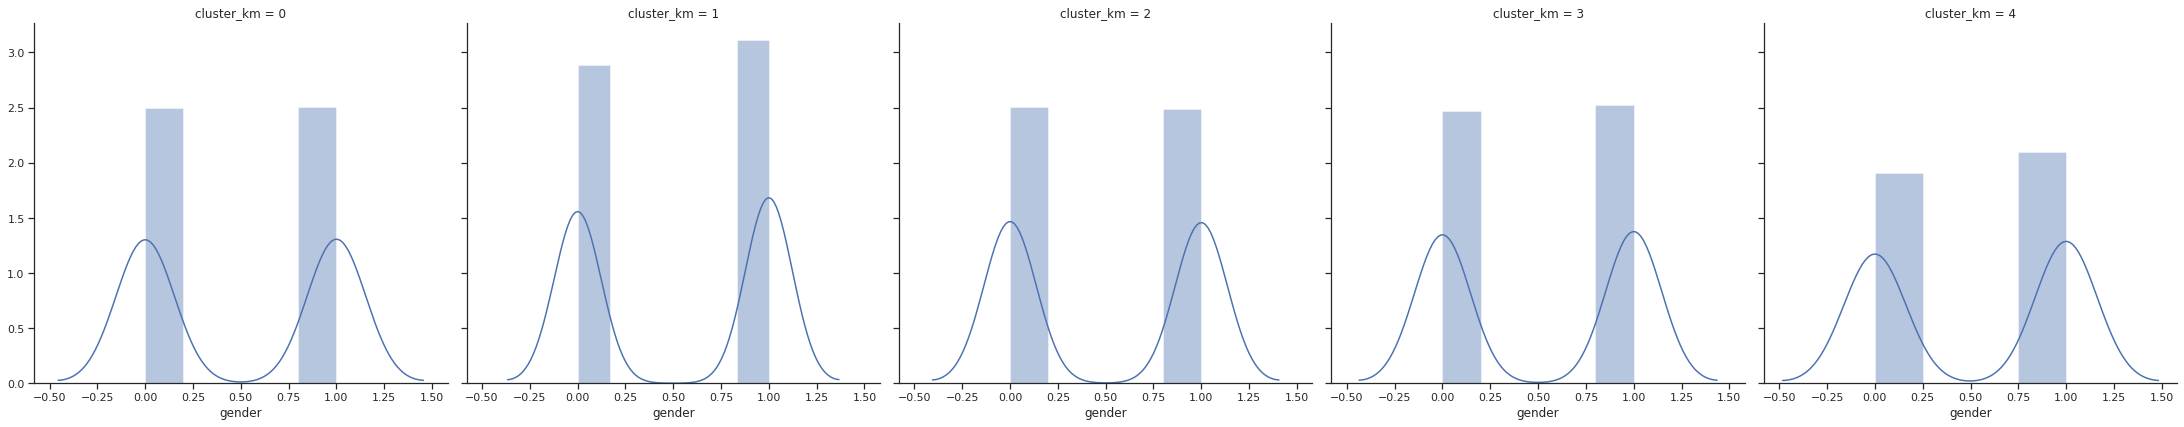

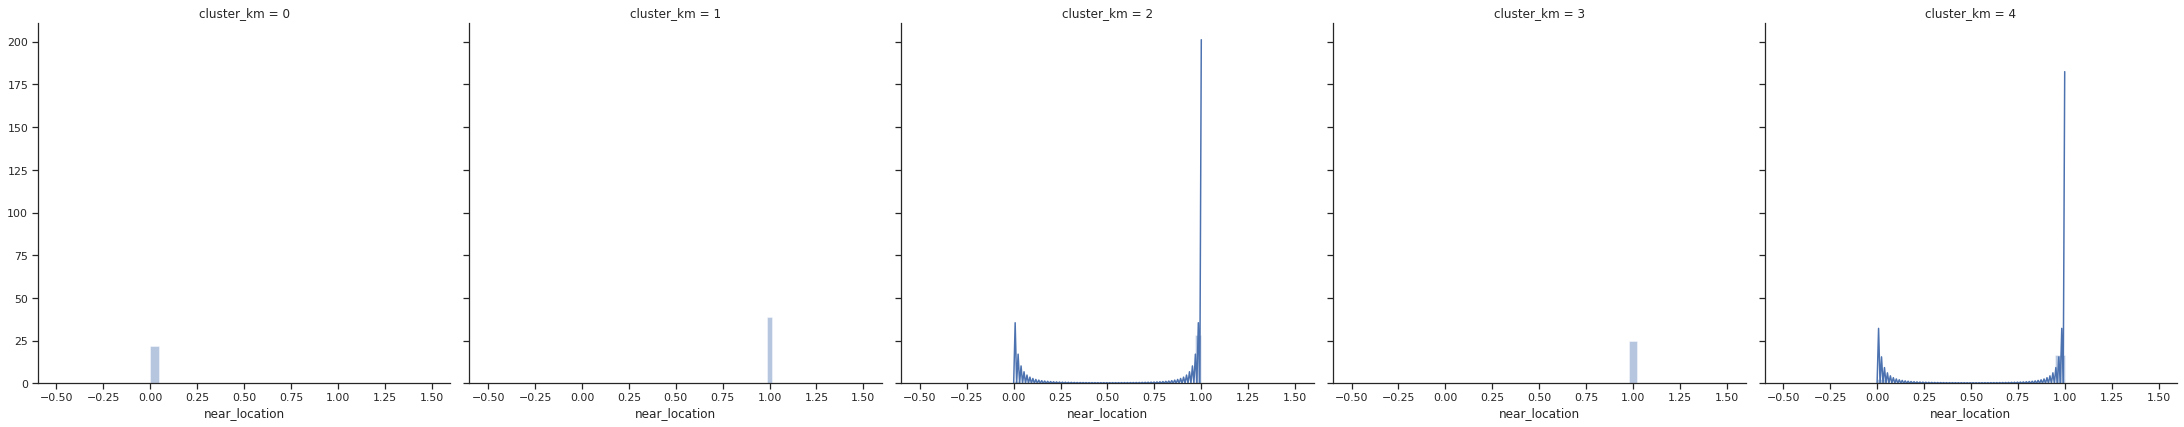

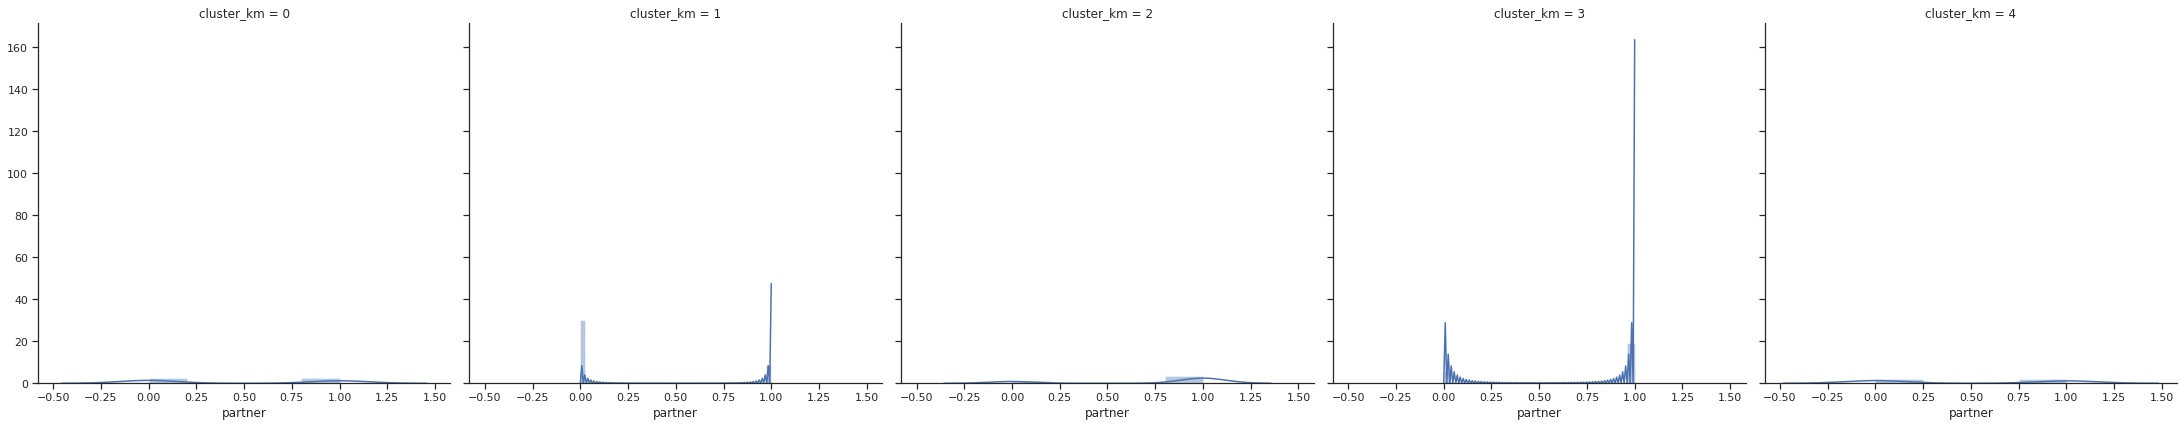

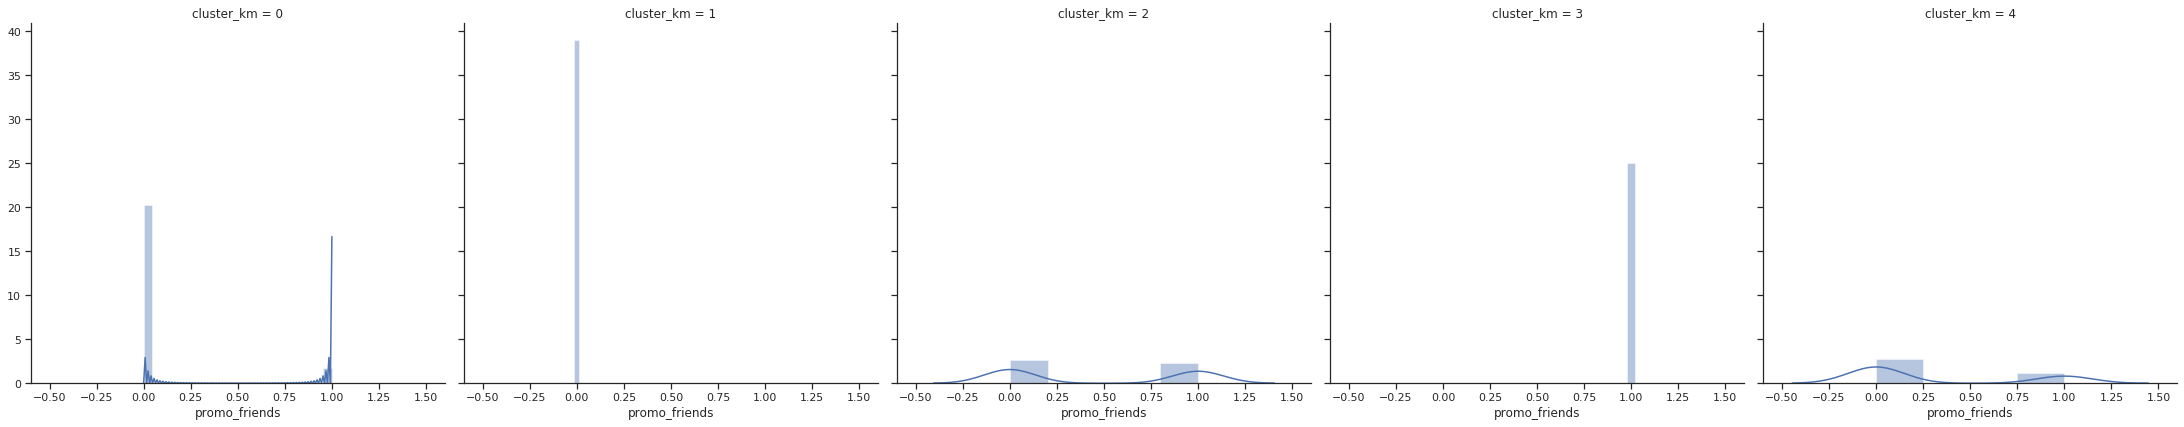

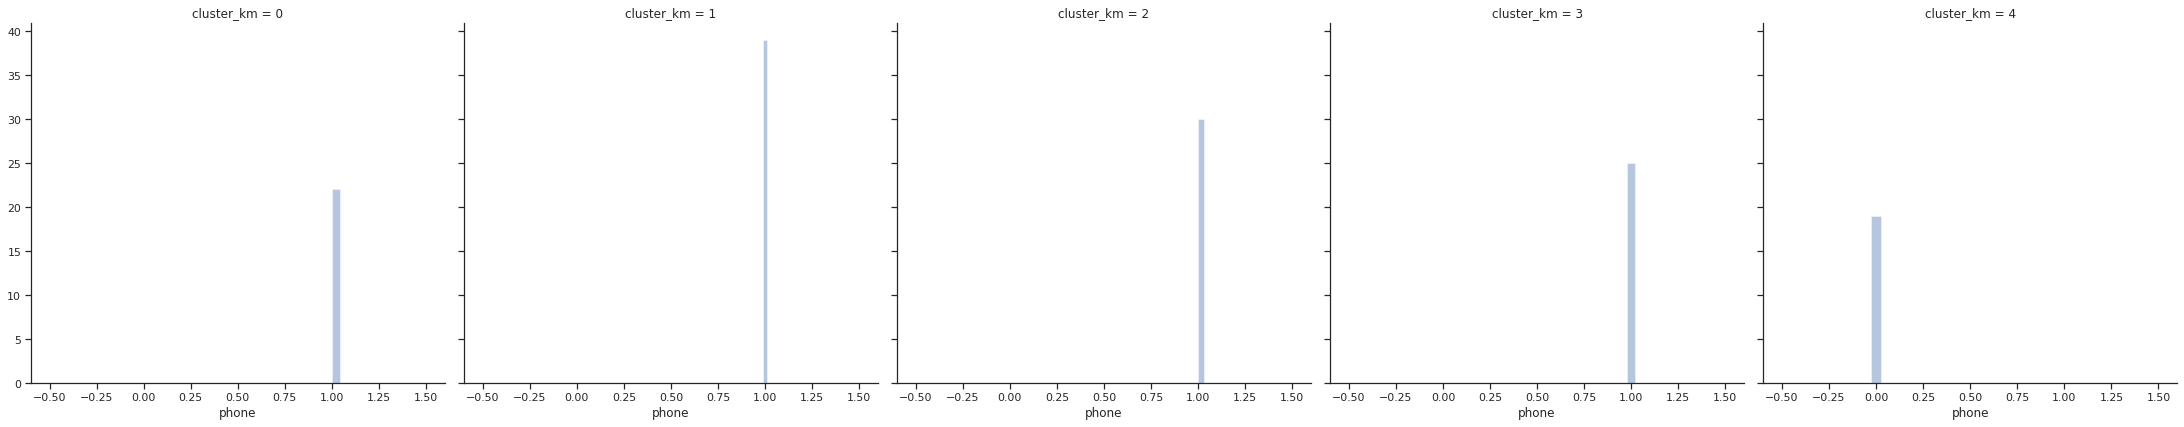

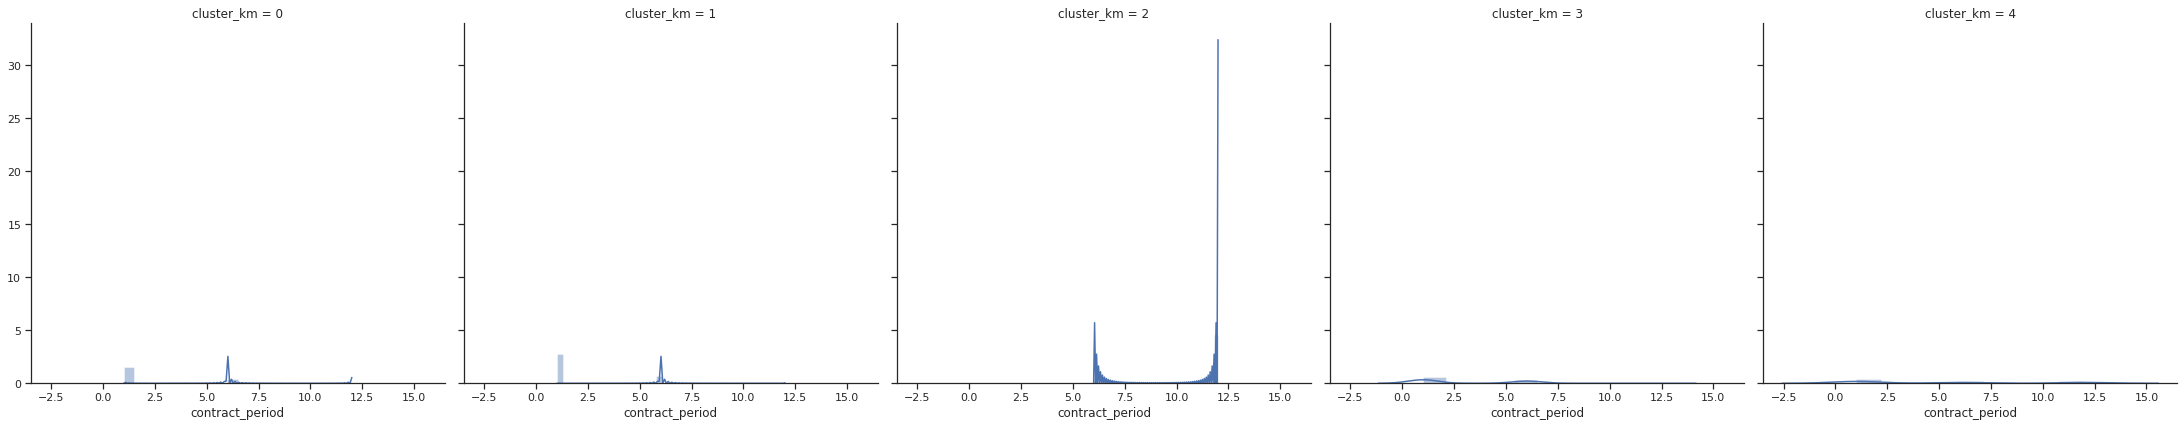

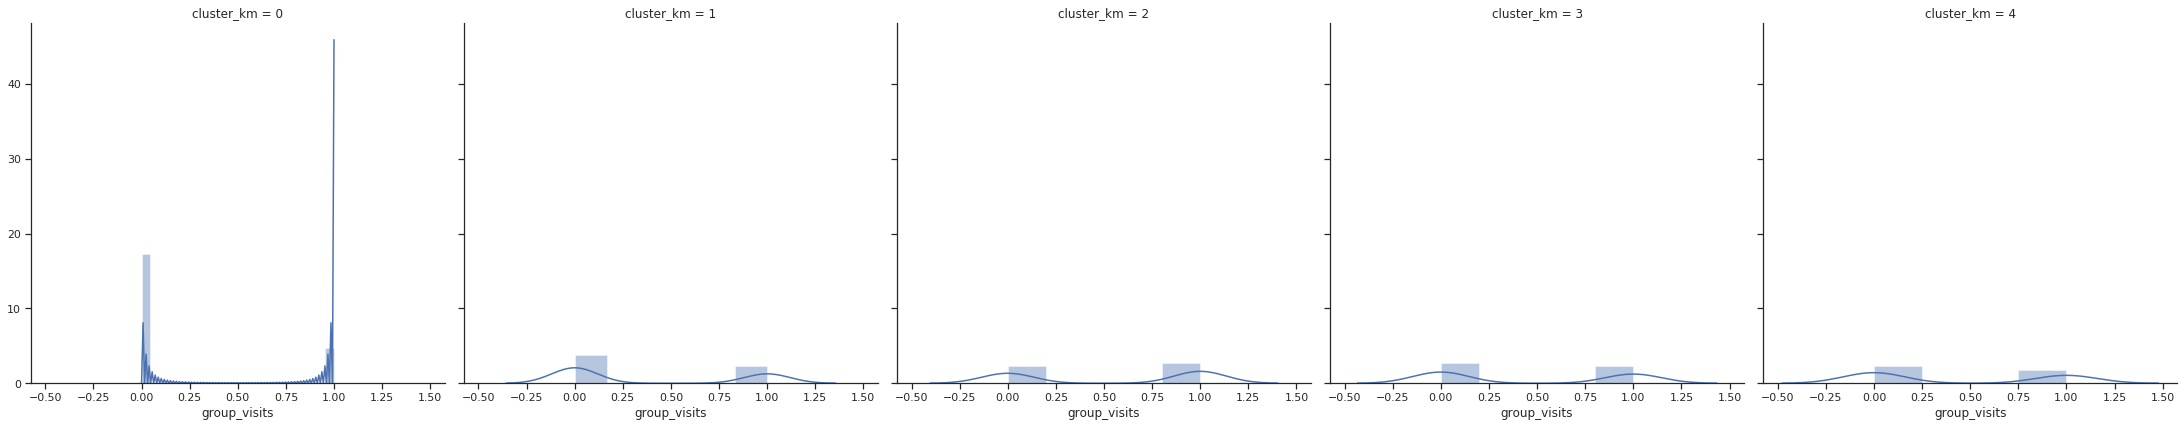

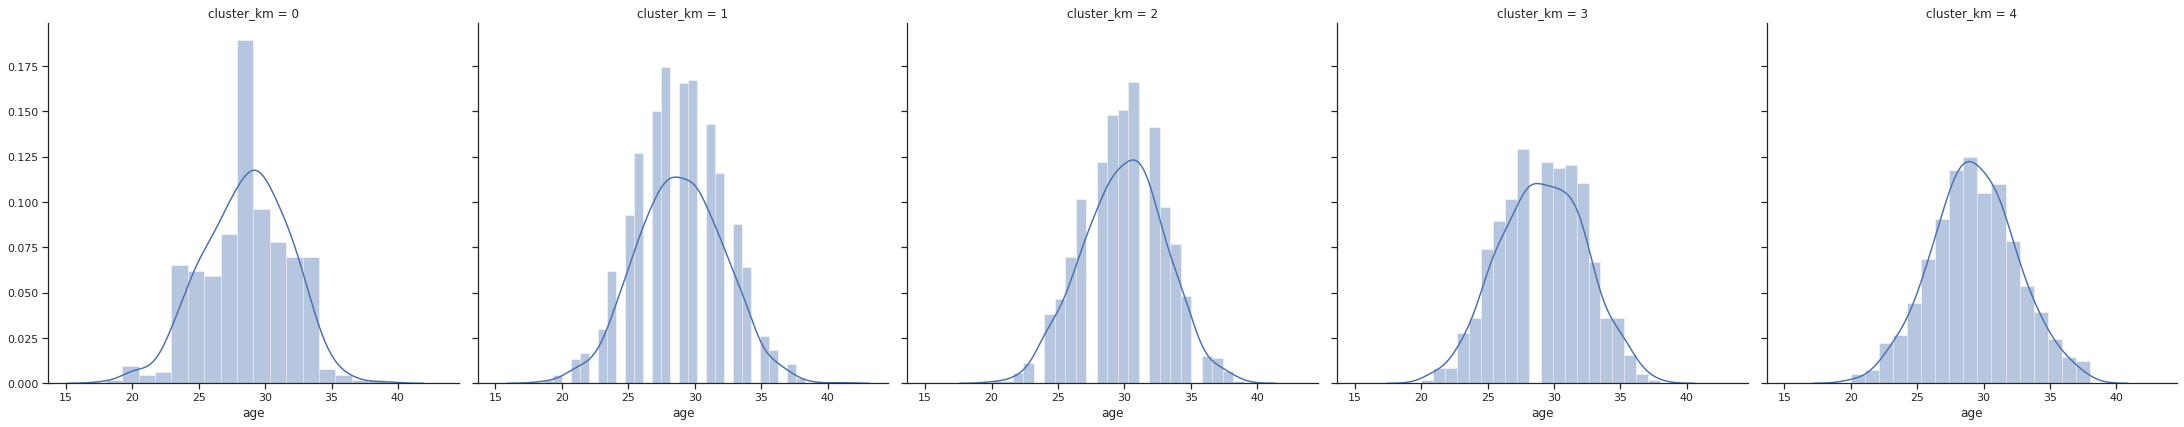

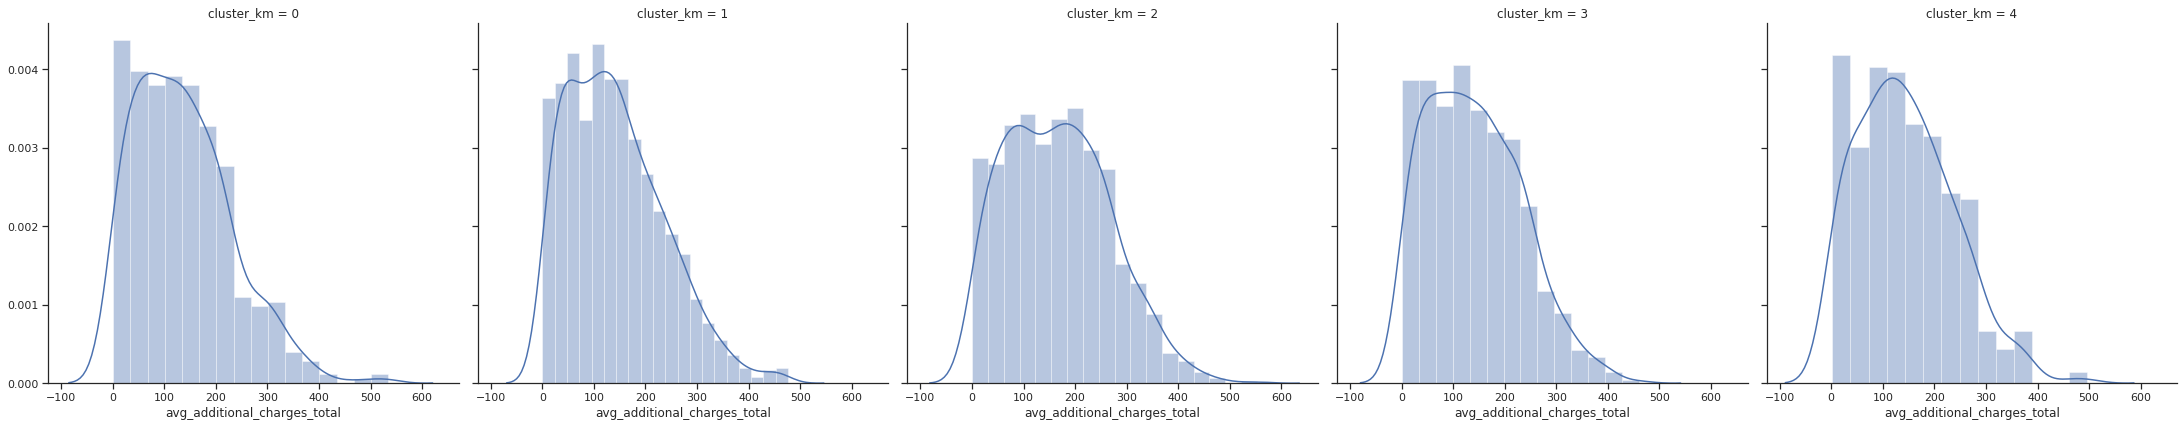

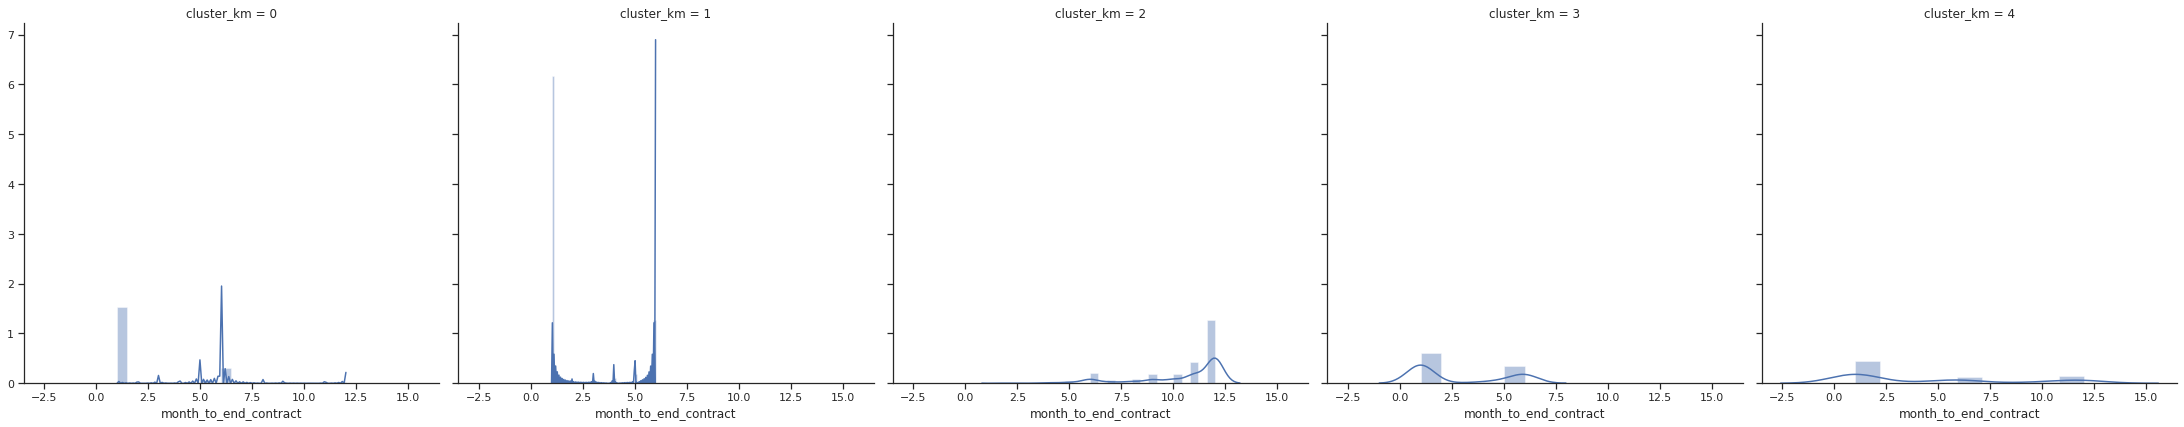

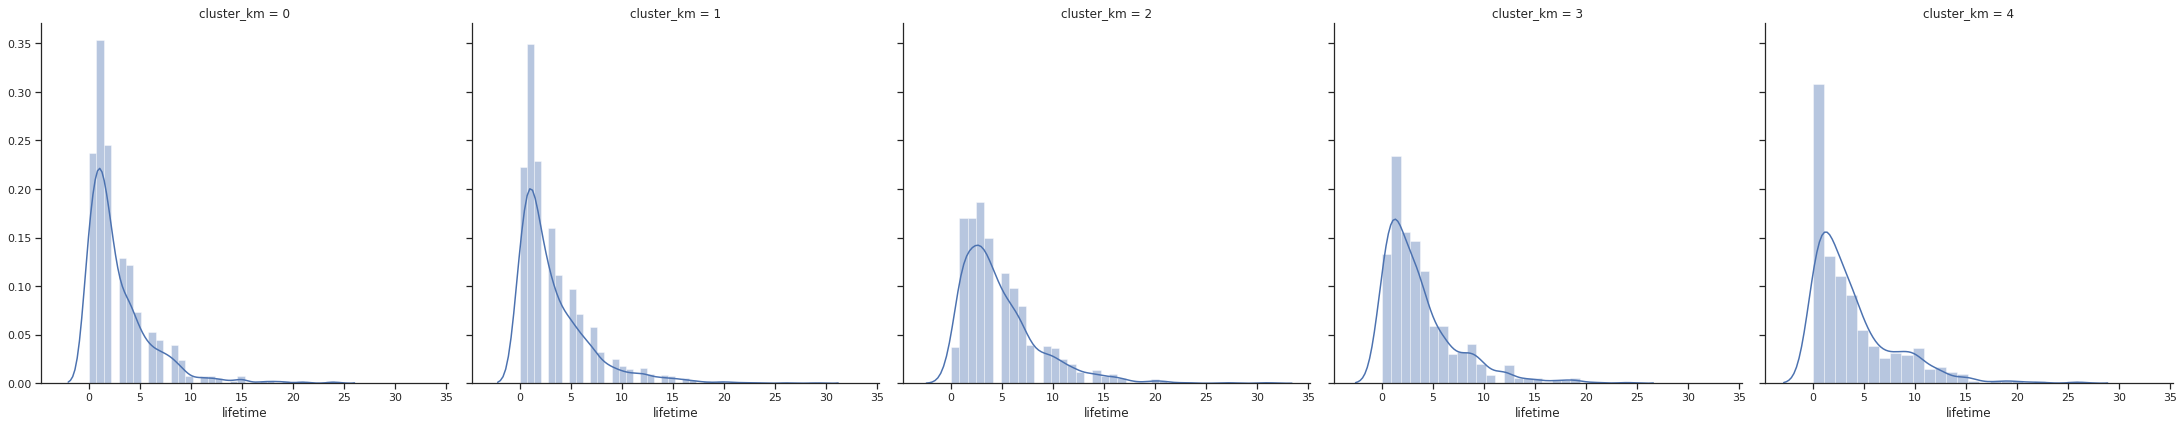

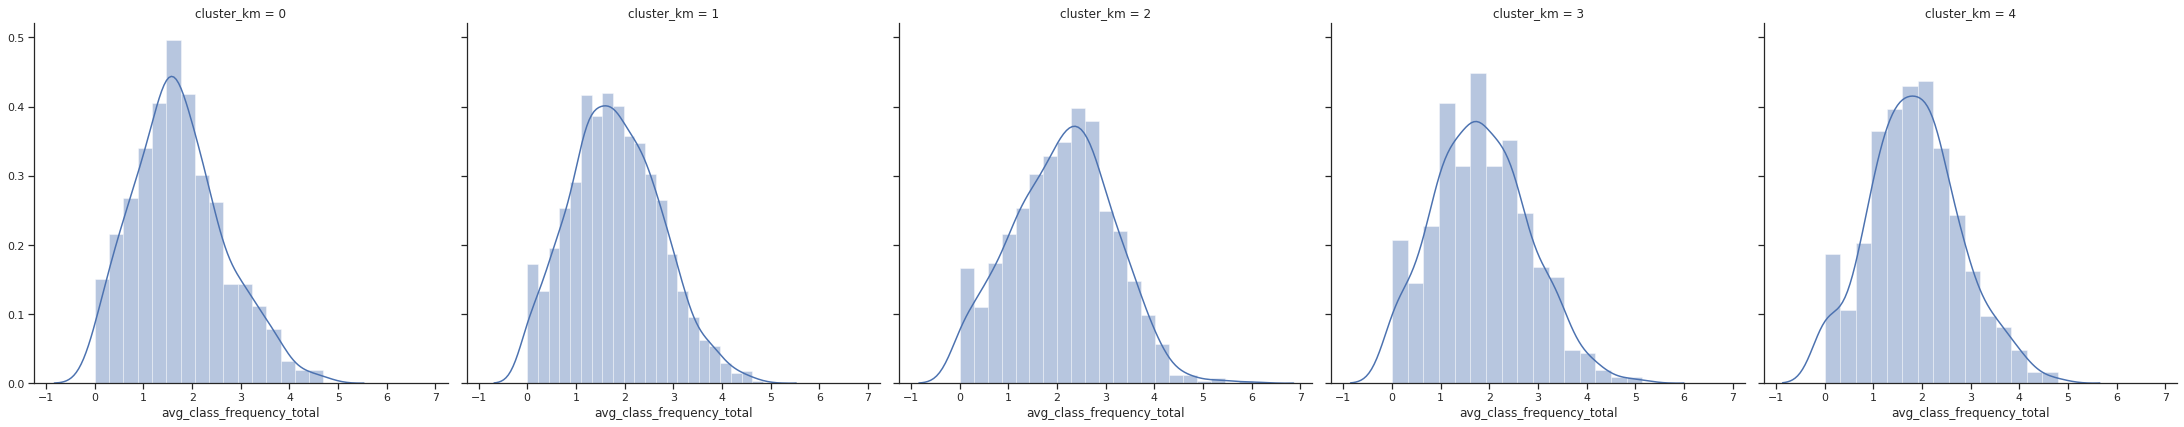

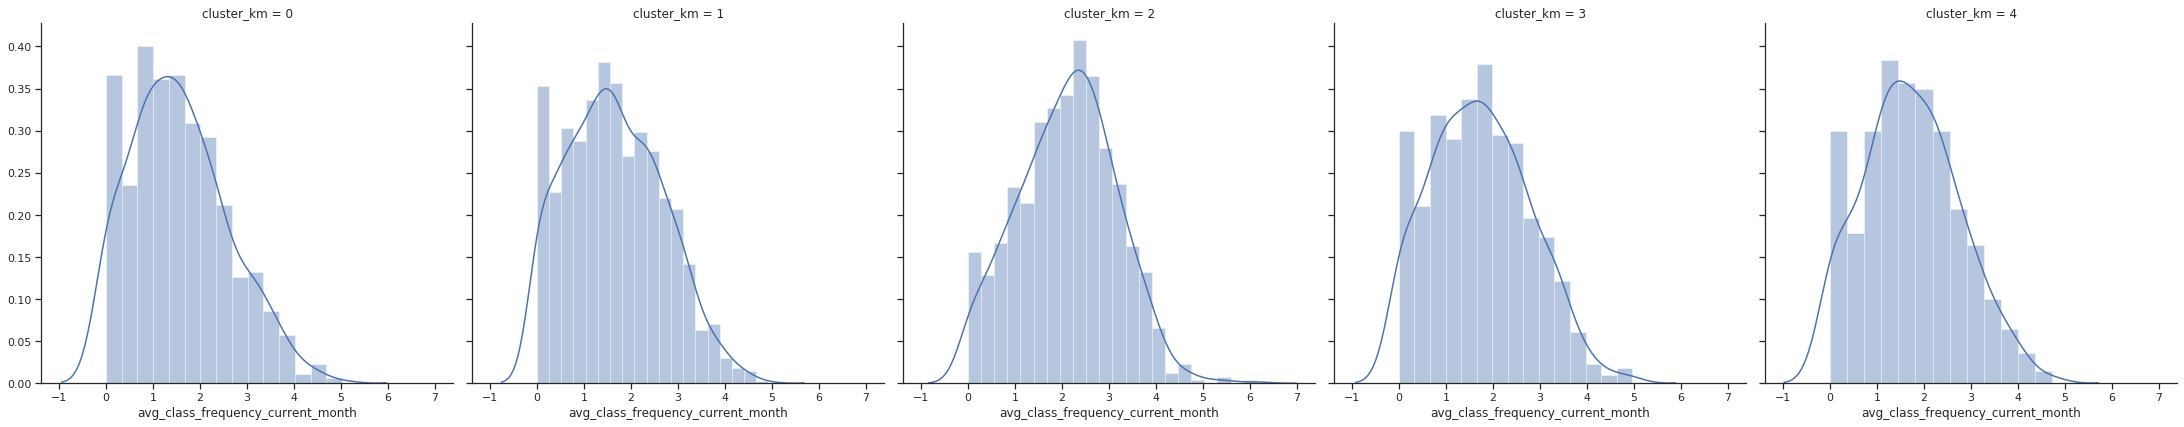

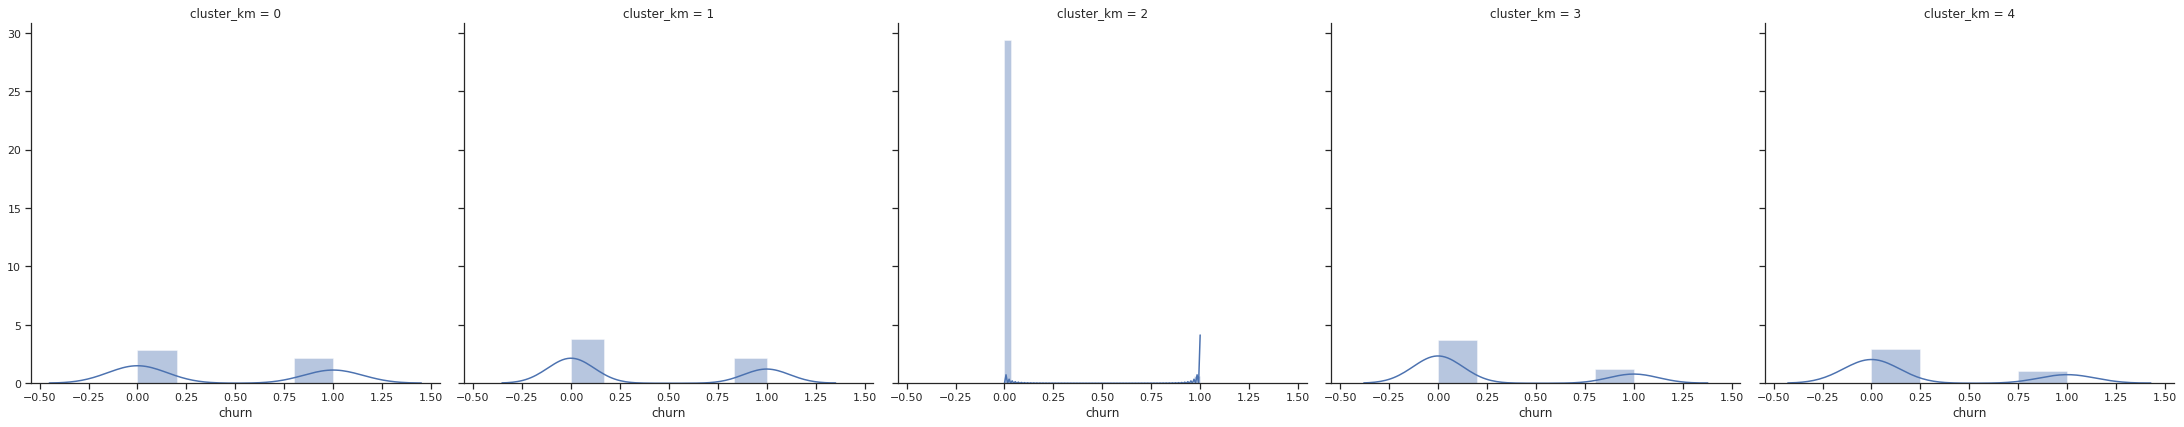

In [17]:
for column in gym_data.drop('cluster_km',axis=1).columns:
    g = sns.FacetGrid(gym_data, col='cluster_km',height=6.1, col_wrap=5) #, sharey = True
    g = (g.map(sns.distplot, column, hist=True, rug=False))

Из графиков распределений видно, что средняя частота посещений в неделю за предыдущий месяц в **группе 0 и 1** сильно скошена влево. Тоесть, большое количество клиентов или очень редко ходили в предыдущем месяце или вообще не ходили. Это хорошее дополнение к предшествующему анализу. 

## Выводы

1. Предоставленные данные являются качественными и необходимые признаки для проведения анализа подобраны хорошо.
Были отмечены только 2 пары признаков, у которых наблюдается ярко выраженная корреляция:
- `avg_class_frequency_total` и `avg_class_frequency_current_month`
- `contract_period` и `month_to_end_contract`

2. Для прогноза оттока рекомендуется использовать алгоритм **логистической регрессии** или **случайного леса**. По метрикам они показали очень близкие результаты.

3. Для разбивки клиентов на кластеры рекомендуется использовать 6 кластеров. Для уменьшения оттока рекомендуется обратить отдельное внимание на следующие 2 типа клиентов:
- клиенты находятся далеко от зала, не пользуются промо-кодами и не помещают групповые занятия. Скорее всего, данные клиенты характеризуются низкой социальной активностью и с уетом далёкого расположения зала они скорее отказываются от его посещения.
- клиенты находятся близко к залу, но также не пользуются промо-кодами, не помещают групповые занятия, имеют наименьшее среднее число посещений и, соответственно, осталяют мало денег за доп.услуги. Скорее всего, данные клиенты купили абонимент, опираясь только на близость, но мотивации заниматься у них нет.

4. Следует более активно распространять промо-коды и привлекать клиентов к групповым занятиям. Возможно, часть из них стоит сделать бесплатными. Это поможет снизить отток.